In [1]:
# 使用するライブラリのimport
import os
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


In [10]:
# 定数の宣言
IMAGES_PATH = "images"                                  # 生成画像の出力先フォルダ
DATA_PATH = "data/mnist"                                # テストデータフォルダ

EPOCHS = 100                                             # エポック数
BATCH_SIZE = 64                                          # バッチサイズ

LEARNING_RATE = 0.0002                                 # Adam：学習率
B1 = 0.5                                                   # 勾配のモメンタム １
B2 = 0.999                                                # 勾配のモメンタム 2

LATENT_DIM = 100                                        # 潜在変数（z)の次元数
IMG_SIZE = 32                                             # 画像の幅と高さ
CHANNELS = 1                                             # 画像のチャンネル数（１＝グレー）
img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)             # イメージ画像（チャンネル、幅、高さ）

SAMPLE_INTERVAL = 50                                   # 生成画像サンプリングのタイミング

cuda = True if torch.cuda.is_available() else False          # GPUの利用チェック
print('GPU Check! cuda is ', cuda)


GPU Check! cuda is  True


In [11]:
# 重みの初期化関数
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [12]:
# Generatorの定義
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = IMG_SIZE // 4
        self.l1 = nn.Sequential(nn.Linear(LATENT_DIM, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, CHANNELS, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [13]:
# Discriminatorの定義
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(CHANNELS, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = IMG_SIZE // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


In [14]:
# 損失関数：バイナリクロスエントロピー誤差
adversarial_loss = torch.nn.BCELoss()

# GeneratorとDiscriminatorのインスタンス化
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# 重みの初期化
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# MNISTデータの読み込み
os.makedirs(DATA_PATH, exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        DATA_PATH,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# 生成画像の出力フォルダの作成
os.makedirs(IMAGES_PATH, exist_ok=True)

In [15]:
# 最適化関数のセット
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(B1, B2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [16]:
# ----------
#  学習
# ----------
img_list = []
G_losses = []
D_losses = []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):

        # サンプルノイズの生成(正規分布に従ったランダムな値)
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], LATENT_DIM))))

        # 判定ラベル
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)


        # テスト画像
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Discriminatorの学習
        # ---------------------
        optimizer_D.zero_grad()

        # テスト画像と正解ラベルのペアで損失を計算
        real_loss = adversarial_loss(discriminator(real_imgs), valid)

        # G(z)と偽物ラベルのペアで損失を計算
        fake_imgs = generator(z)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake)

        # それぞれのLossを加算してDiscriminatorの損失
        d_loss = real_loss + fake_loss

        # 損失の誤差逆伝播
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Generatorの学習
        # -----------------
        optimizer_G.zero_grad()

        # D(G(z))と正解ラベルで損失を計算
        g_loss = adversarial_loss(discriminator(fake_imgs), valid)

        # 損失の誤差逆伝播
        g_loss.backward()
        optimizer_G.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, EPOCHS, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % SAMPLE_INTERVAL == 0:
            save_image(fake_imgs.data[:25], IMAGES_PATH + "/%07d.png" % batches_done, nrow=5, normalize=True)
            # ログ情報の収集
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            img_list.append(fake_imgs.data[:25])

ストリーミング出力は最後の 5000 行に切り捨てられました。
[Epoch 94/100] [Batch 628/938] [D loss: 0.326305] [G loss: 2.161291]
[Epoch 94/100] [Batch 629/938] [D loss: 0.185622] [G loss: 2.262796]
[Epoch 94/100] [Batch 630/938] [D loss: 0.220206] [G loss: 2.328736]
[Epoch 94/100] [Batch 631/938] [D loss: 0.281161] [G loss: 3.192349]
[Epoch 94/100] [Batch 632/938] [D loss: 2.119568] [G loss: 1.137979]
[Epoch 94/100] [Batch 633/938] [D loss: 0.981573] [G loss: 0.160802]
[Epoch 94/100] [Batch 634/938] [D loss: 2.648500] [G loss: 0.665215]
[Epoch 94/100] [Batch 635/938] [D loss: 0.446156] [G loss: 0.898691]
[Epoch 94/100] [Batch 636/938] [D loss: 0.794828] [G loss: 1.840402]
[Epoch 94/100] [Batch 637/938] [D loss: 0.684636] [G loss: 1.918563]
[Epoch 94/100] [Batch 638/938] [D loss: 0.451435] [G loss: 0.514764]
[Epoch 94/100] [Batch 639/938] [D loss: 0.406685] [G loss: 1.991684]
[Epoch 94/100] [Batch 640/938] [D loss: 0.180636] [G loss: 1.209830]
[Epoch 94/100] [Batch 641/938] [D loss: 1.213360] [G loss: 2.045900]
[E

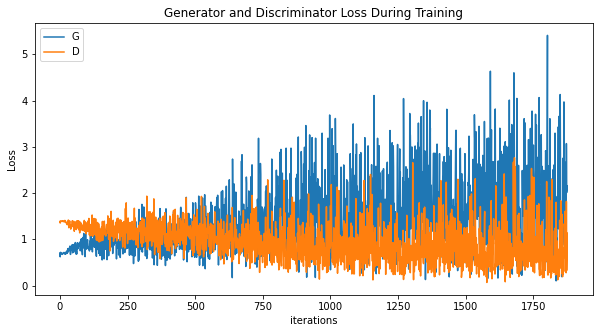

In [17]:
# 学習結果の可視化
import torchvision.utils as vutils
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 生成した画像をアニメーションGIFとして保存する
imgs = []
    
# 保存しているtorch.TensorをPil Imageに変換する
i = 0
for img in img_list :
  if(i%10) == 0:
      img_temp = vutils.make_grid(img, padding=2, nrow=5, normalize=True)
      imgs.append(transforms.functional.to_pil_image(img_temp))
  i += 1
    
imgs[0].save(
    "./Generator.gif", save_all=True, append_images=imgs[1:], duration=500, loop=0
)